In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import const

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gym_environment
env = gym_environment.Environment()

class DQN(nn.Module):
	def __init__(self, observation_size, action_size):
		super().__init__()
		# self.fc1 = nn.Linear(observation_size, HIDDEN_LAYER_SIZE)
		# self.fc2 = nn.Linear(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE)
		# self.fc3 = nn.Linear(HIDDEN_LAYER_SIZE, action_size)
		self.fc1 = nn.Linear(observation_size, 16)
		self.fc2 = nn.Linear(16, 32)
		self.fc3 = nn.Linear(32, 64)
		self.fc4 = nn.Linear(64, action_size)

	def forward(self, x):
		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = F.relu(self.fc3(x))
		return self.fc4(x)
	
action_size = env.action_space.n
state, _ = env.reset()
observation_size = len(state)
print(action_size)

policy_net = DQN(observation_size, action_size).to("cpu")
policy_net.load_state_dict(torch.load("subtract_4_3k_random_weather.pt", map_location="cpu"))


3


<All keys matched successfully>

1
-1.4971425797219913
1
-1.6206278092177924
1
-1.668465910243947
1
-1.676963339579186
1
-1.6629797394168264
1
-1.6429832423703292
1
-1.6150660045932066
1
-1.5843566247357799
1
-1.5481532936030338
1
-1.5224611160609858
1
-1.4926841422531156
1
-1.4680985206129364
1
-1.4478528321156425
1
-1.4254861782334827
1
-1.4089745462597079
1
-1.3967011390607302
1
-1.3875144235220802
1
-1.392052472063897
1
-1.4039943459628939
1
-1.4079123270570786
1
-1.4071172159422654
2
-1.4037349534689372
2
-1.3933738388465968
2
-1.379719356019736
2
-1.370754831659466
2
-1.3649357608077766
2
-1.3612149670844857
2
-1.3531533658478094
2
-1.3488690609299712
2
-1.3469462791433393
2
-1.340724555193062
2
-1.3324647265553604
2
-1.323549445328101
2
-1.3147897048486183
2
-1.300898478822743
2
-1.2906839227067042
2
-1.2888528635834997
2
-1.2918136973993202
2
-1.3030100652216785
2
-1.3181531513782343
2
-1.3288842453081582
2
-1.342252924964908
2
-1.3505819210795464
2
-1.361338341532127
2
-1.3670905346389537
2
-1.363978569104094

4

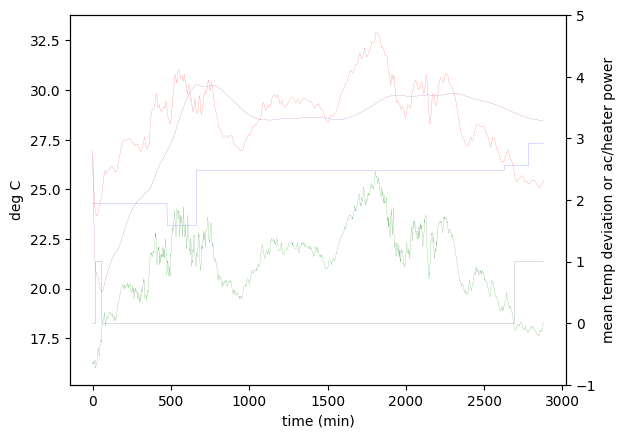

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import const
import random
import time
import agents.dumb_agent

fig, ax1 = plt.subplots()
ax1.set_xlabel("time (min)")
# ax1.set_ylim(10, 30)
# ax1.set_yticks(np.arange(10, 31))
ax1.set_ylabel("deg C")

ax2 = ax1.twinx()
ax2.set_ylim(-1, 5)
ax2.set_ylabel("mean temp deviation or ac/heater power")

sim_max = 2880

# weather_start = 695991
weather_start = random.randrange(0, len(const.OUTSIDE_TEMP) - sim_max)

xvalues = np.arange(0, sim_max)
temperatures = np.zeros(sim_max)
setpoints = np.zeros(sim_max)
outside_temp = np.zeros(sim_max)
on_off = np.zeros(sim_max)
mean_dev = np.zeros(sim_max)
old_action = 0
cycles = 0

deviation_sum = 0

state, _ = env.reset(num_setpoints=5, length=sim_max, start_time=weather_start)

for i in range(sim_max):	
	# power = policy_net(torch.tensor(state)).max(0).indices.view(1, 1).item()
	power = agents.dumb_agent.agent(env.get_cur_temp(), const.OUTSIDE_TEMP[weather_start + i], env.get_setpoint(), env._actions[old_action])
	power = env._actions.index(power)
	# if env._sgn(power) != env._sgn(old_action):
	if power != old_action:
		cycles += 1
	old_action = power

	temperatures[i] = env.get_cur_temp()
	setpoints[i] = env.get_setpoint()
	outside_temp[i] = const.OUTSIDE_TEMP[weather_start + i]

	on_off[i] = env._actions[power]

	deviation_sum += abs(temperatures[i] - env.get_setpoint())
	state, reward, _ = env.step(power)

	mean_dev[i] = deviation_sum / (i + 1)

ax1.plot(xvalues, temperatures, color="red", linewidth=0.1)
ax1.plot(xvalues, setpoints, color="blue", linewidth=0.1)
ax1.plot(xvalues, outside_temp, color="green", linewidth=0.1)
ax2.plot(xvalues, on_off, color="black", linewidth=0.1)
ax2.plot(xvalues, mean_dev, color="purple", linewidth=0.1)
# plt.show()
plt.savefig("old2.png", dpi=1000)

cycles
# m2K/W * m2 * K